In [1]:
# =====================================================================
# 0. IMPORTS, PATHS & PRESET
# =====================================================================
import os
import re
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, Dataset

# directories
CACHE_DIR    = "/tmp/coords_cache"
COMP_DIR     = "/kaggle/input/stanford-rna-3d-folding"
EXT_DIR_UW   = "/kaggle/input/dataset"
EXT_DIR_RIBO = "/kaggle/input/dataset"

CAP = 100.0

os.makedirs(CACHE_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"RUNNING ON {DEVICE}, GPUs: {torch.cuda.device_count()}")

# =====================================================================
# 1. PRESET → HYPER-PARAMETERS
# =====================================================================
PRESET = "quick"
if PRESET == "quick":
    D_MODEL, NUM_HEADS, TF_LAYERS, EGNN_LAYERS = 32, 4, 2, 4
    BATCH_SIZE, MAX_LEN, NUM_EPOCHS, LR         = 6, 512, 5, 3e-3
elif PRESET == "highacc":
    D_MODEL, NUM_HEADS, TF_LAYERS, EGNN_LAYERS = 96, 12, 6, 6
    BATCH_SIZE, MAX_LEN, NUM_EPOCHS, LR         = 4, 512, 20, 3e-4
else:
    D_MODEL, NUM_HEADS, TF_LAYERS, EGNN_LAYERS = 64, 8, 4, 4
    BATCH_SIZE, MAX_LEN, NUM_EPOCHS, LR         = 6, 512, 10, 3e-4


UW_SAMPLE_COUNT   = 10000  #446034
RIBO_SAMPLE_COUNT = 124902  #124902
DISTOGRAM_BINS    = 32
W_GEO_LOSS        = 0.0
W_SOFT_TM_LOSS    = 1.5
W_SPREAD_LOSS     = 0.7
W_REGULARIZATION  = 0.05
W_DISTOGRAM       = 0.6
W_RMSE = 3.0  # weight for RMSE term
TARGET_STD = 1

RUNNING ON cuda, GPUs: 2


In [2]:
# =====================================================================
# 2. BUILD C1′ COORDINATE CACHE (once at startup, NaN‐first)
# =====================================================================
import os, re, numpy as np, pandas as pd, pyarrow.parquet as pq
from tqdm import tqdm

def _xyz_cols(cols):
    return sorted(cols, key=lambda c: (int(c.split('_')[1]), 'xyz'.index(c[0])))

def build_cache():
    sources = [
        f"{COMP_DIR}/train_labels.csv",
        f"{COMP_DIR}/train_labels.v2.csv",
        f"{COMP_DIR}/validation_labels.csv",
        f"{EXT_DIR_UW}/ext_labels.parquet",
        f"{EXT_DIR_RIBO}/ext_ribonanza_labels.parquet",
    ]
    for path in sources:
        desc = os.path.basename(path)
        if not os.path.exists(path):
            print(f"→ Skipping {desc}")
            continue

        # load
        if path.endswith(".parquet"):
            df = pq.read_table(path).to_pandas()
        else:
            df = pd.read_csv(path)

        # detect ID column
        id_col = next((c for c in df.columns 
                       if c.lower() in ("id","target_id")), None)
        if id_col is None:
            raise RuntimeError(f"No ID/target_id column in {desc}")

        # split into tid, idx
        df[['tid','idx']] = (
            df[id_col]
              .astype(str)
              .str.rsplit(pat="_", n=1, expand=True)
        )
        df['idx'] = df['idx'].astype(int)

        # pick out xyz columns
        cols = [c for c in df.columns if re.match(r"[xyz]_\d+$", c)]
        cols = _xyz_cols(cols)
        if not cols:
            raise RuntimeError(f"No coordinate columns in {desc}")

        # build and save numpy arrays
        for tid, grp in tqdm(df.groupby("tid"), desc=desc, leave=False):
            arr = grp.sort_values("idx")[cols] \
                     .to_numpy(np.float32) \
                     .reshape(-1, 1, 3)
            # zero NaNs, drop sentinel
            arr = np.nan_to_num(arr, nan=0.0)
            arr[arr < -1e17] = 0.0
            np.save(os.path.join(CACHE_DIR, f"{tid}.npy"),
                    arr, allow_pickle=False)

# only build once
if not os.listdir(CACHE_DIR):
    print("🗄️  Building cache…")
    build_cache()
else:
    print("🗄️  Cache ready:", len(os.listdir(CACHE_DIR)), "files")

cached_ids = {fn[:-4] for fn in os.listdir(CACHE_DIR)
              if fn.endswith(".npy")}
def keep_cached(df):
    return df[df.target_id.isin(cached_ids)] \
             .reset_index(drop=True)

🗄️  Building cache…


In [3]:
# =====================================================================
# 3. DATASETS & DATALOADERS (with coordinate normalization)
# =====================================================================
import os, numpy as np, pandas as pd, pyarrow.parquet as pq, torch
from torch.utils.data import Dataset, DataLoader

VOC = {c:i for i,c in enumerate("ACGU")}
VOC["<PAD>"], VOC["<UNK>"] = len(VOC), len(VOC)+1
VOC_SIZE = len(VOC)

def one_hot(seq, max_len):
    M = np.zeros((max_len, VOC_SIZE), np.float32)
    for i,ch in enumerate(seq[:max_len]):
        M[i, VOC.get(ch, VOC["<UNK>"])] = 1.0
    return M

class LazyRNA(Dataset):
    def __init__(self, df, max_len, cache_dir):
        self.df, self.max_len, self.cache_dir = df.reset_index(drop=True), max_len, cache_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        tid, seq = row.target_id, row.sequence
        L = len(seq)
        clip = min(L, self.max_len)

        feat = torch.from_numpy(one_hot(seq, self.max_len))

        # load & pad true coords
        try:
            arr = np.load(f"{self.cache_dir}/{tid}.npy", mmap_mode="r")
        except FileNotFoundError:
            arr = np.zeros((0,1,3), np.float32)
        arr = np.nan_to_num(arr, nan=0.0)
        arr[arr < -1e17] = 0.0
        arr = arr / CAP
        coords_np = np.zeros((self.max_len,1,3), np.float32)
        clip_len  = min(arr.shape[0], self.max_len)
        coords_np[:clip_len] = arr[:clip_len]

        # ---- normalize here ----
       # coords_np /= CAP

        coords = torch.from_numpy(coords_np)
        mask   = torch.arange(self.max_len) < clip

        return tid, feat, coords, mask

def load_and_filter(path, keep_ids):
    df = (pq.read_table(path).to_pandas()
          if path.endswith(".parquet") else pd.read_csv(path))
    if "ID" in df.columns and "target_id" not in df.columns:
        df = df.rename(columns={"ID":"target_id"})
    return df[df.target_id.isin(keep_ids)].reset_index(drop=True)

# assume CACHE_DIR & COMP_DIR, EXT_DIR_UW, EXT_DIR_RIBO built already...
cached_ids = {fn[:-4] for fn in os.listdir(CACHE_DIR) if fn.endswith(".npy")}

val_df = load_and_filter(f"{COMP_DIR}/validation_sequences.csv", cached_ids)
t1     = load_and_filter(f"{COMP_DIR}/train_sequences.csv",      cached_ids)
try:
    t2 = load_and_filter(f"{COMP_DIR}/train_sequences.v2.csv",  cached_ids)
except FileNotFoundError:
    t2 = pd.DataFrame(columns=['target_id','sequence'])

train_comp = pd.concat([t1,t2],ignore_index=True).drop_duplicates('target_id')
train_comp = train_comp[~train_comp.target_id.isin(val_df.target_id)]

uw = load_and_filter(f"{EXT_DIR_UW}/ext_sequences.parquet", cached_ids)
uw = uw[~uw.target_id.isin(val_df.target_id)].sample(n=min(UW_SAMPLE_COUNT,len(uw)),random_state=42)

ribo = load_and_filter(f"{EXT_DIR_RIBO}/ext_ribonanza_sequences.parquet", cached_ids)
ribo = ribo[~ribo.target_id.isin(val_df.target_id)].sample(n=min(RIBO_SAMPLE_COUNT,len(ribo)),random_state=42)

train_df = pd.concat([train_comp,uw,ribo],ignore_index=True).drop_duplicates('target_id').reset_index(drop=True)

train_loader = DataLoader(
    LazyRNA(train_df, MAX_LEN, CACHE_DIR),
    batch_size=BATCH_SIZE, shuffle=True,
    num_workers=2, pin_memory=True, drop_last=True
)
val_loader = DataLoader(
    LazyRNA(val_df,   MAX_LEN, CACHE_DIR),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)
print(f"TRAIN SIZE: {len(train_df):,}, VAL SIZE: {len(val_df):,}")

TRAIN SIZE: 140,281, VAL SIZE: 12


In [4]:
# =====================================================================
# 3. SANITY CHECK
# =====================================================================
print("\nExample batch from val_loader:")
for tid, feat, coords, mask in val_loader:
    print(" ", feat.shape, coords.shape, mask.sum().item())
    break


Example batch from val_loader:
  torch.Size([6, 512, 6]) torch.Size([6, 512, 1, 3]) 926


In [5]:
# ---------------------------------------------------------------------
# Print out how many rows (i.e. sequences) are in each file
# ---------------------------------------------------------------------
import os
import pandas as pd

# adjust these to your actual paths
COMP_DIR     = "/kaggle/input/stanford-rna-3d-folding"          # competition data
UW_DIR       = "/kaggle/input/dataset"   # UW external data
DATASET_DIR  = "/kaggle/input/dataset"                        # your “dataset” folder

def count_rows_in_dir(name, directory):
    print(f"\n{name} ({directory}):")
    for fn in sorted(os.listdir(directory)):
        path = os.path.join(directory, fn)
        if fn.endswith(".csv"):
            df = pd.read_csv(path)
            print(f"  {fn:<30s} → {len(df):,} rows")
        elif fn.endswith(".parquet"):
            df = pd.read_parquet(path)
            print(f"  {fn:<30s} → {len(df):,} rows")
        else:
            print(f"  {fn:<30s} → (not a table)")

count_rows_in_dir("Competition sequences/labels", COMP_DIR)
count_rows_in_dir("Additional Dataset",     DATASET_DIR)


# =====================================================================
# 4.  MODEL (Transformer + EGNN + distogram)
#


Competition sequences/labels (/kaggle/input/stanford-rna-3d-folding):
  MSA                            → (not a table)
  sample_submission.csv          → 2,515 rows
  test_sequences.csv             → 12 rows
  train_labels.csv               → 137,095 rows
  train_labels.v2.csv            → 3,677,095 rows
  train_sequences.csv            → 844 rows
  train_sequences.v2.csv         → 5,135 rows
  validation_labels.csv          → 2,515 rows
  validation_sequences.csv       → 12 rows

Additional Dataset (/kaggle/input/dataset):
  USalign                        → (not a table)
  ext_labels.parquet             → 29,757,542 rows
  ext_ribonanza_labels.parquet   → 21,890,650 rows
  ext_ribonanza_sequences.parquet → 124,902 rows
  ext_sequences.parquet          → 446,034 rows


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

In [7]:
# =====================================================================
# 4.  MODEL DEFINITION & INITIALIZATION (EGNN with residual skips, no Tanh)
# =====================================================================
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler

class EGNNLayer(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.edge_mlp  = nn.Sequential(
            nn.Linear(2*d + 1, d),
            nn.SiLU(),
            nn.Linear(d, d)
        )
        self.coord_mlp = nn.Sequential(
            nn.Linear(d, 1),
            nn.SiLU()
        )
        self.node_mlp  = nn.Sequential(
            nn.Linear(2*d, d),
            nn.SiLU(),
            nn.Linear(d, d)
        )
        self.norm = nn.LayerNorm(d, eps=1e-5)

    def forward(self, h, x, m):
        # h: (B,L,d), x: (B,L,3), m: (B,L)
        B, L, _ = x.shape

        # --- edge messages & coords update ---
        xi = x.unsqueeze(2)                     # (B,L,1,3)
        xj = x.unsqueeze(1)                     # (B,1,L,3)
        dij = (xj - xi).norm(dim=-1, keepdim=True).clamp(min=1e-6)

        hi = h.unsqueeze(2).expand(-1,-1,L,-1)   # (B,L,L,d)
        hj = h.unsqueeze(1).expand(-1,L,-1,-1)   # (B,L,L,d)
        e  = self.edge_mlp(torch.cat([hi, hj, dij], dim=-1)).clamp(-10,10)

        shift  = self.coord_mlp(e).clamp(-10,10) * (xj - xi).clamp(-10,10)
        mask2  = m.unsqueeze(1).unsqueeze(-1)    # (B,1,L,1)
        x      = x + (shift * mask2).sum(dim=2)

        # --- node update with residual skip ---
        agg  = (e * mask2).sum(dim=2)            # (B,L,d)
        h0   = h
        h1   = self.node_mlp(torch.cat([h0, agg], dim=-1))
        h    = self.norm(h0 + h1) * m.unsqueeze(-1)

        return h, x

class RNAFold(nn.Module):
    def __init__(self):
        super().__init__()
        # input projection
        self.inp     = nn.Linear(VOC_SIZE, D_MODEL)
        self.in_norm = nn.LayerNorm(D_MODEL, eps=1e-5)

        # positional embeddings
        self.pos_emb = nn.Parameter(torch.zeros(MAX_LEN, D_MODEL))

        # Transformer encoder layers
        self.trf_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=D_MODEL,
                nhead=NUM_HEADS,
                dim_feedforward=D_MODEL*4,
                dropout=0.1,
                batch_first=True
            )
            for _ in range(TF_LAYERS)
        ])
        self.trf_norms = nn.ModuleList([
            nn.LayerNorm(D_MODEL, eps=1e-5)
            for _ in range(TF_LAYERS)
        ])

        # EGNN layers
        self.egnn = nn.ModuleList([
            EGNNLayer(D_MODEL) for _ in range(EGNN_LAYERS)
        ])

        # coordinate head: plain linear (no Tanh)
        self.out = nn.Sequential(
            nn.LayerNorm(D_MODEL, eps=1e-5),
            nn.Linear(D_MODEL, 40*3),
        )
        # (optional) learnable scale if you want:
        # self.scale = nn.Parameter(torch.tensor(1.0))

        # distogram head
        self.dist = nn.Sequential(
            nn.LayerNorm(D_MODEL, eps=1e-5),
            nn.Linear(D_MODEL, DISTOGRAM_BINS),
        )

    def forward(self, f, c, m):
        # f: (B, L, VOC_SIZE)
        # c: (B, L, 1, 3)
        # m: (B, L) boolean mask
        B, L, _, _ = c.shape
        x = c.squeeze(2)  # (B, L, 3)

        # initial embedding + positional encoding
        h = self.in_norm(self.inp(f)) + self.pos_emb[:L].unsqueeze(0)

        # Transformer encoding
        for layer, norm in zip(self.trf_layers, self.trf_norms):
            h = layer(h, src_key_padding_mask=~m)
            h = norm(h)

        # EGNN layers
        for eg in self.egnn:
            h, x = eg(h, x, m)

        # outputs
        coords  = self.out(h).view(B, MAX_LEN, 40, 3)  # (B, L, 40, 3)
        # if using scale: coords = coords * self.scale
        dlogits = self.dist(h).clamp(-20, 20)          # (B, L, BINS)
        return coords, dlogits

# instantiate & init weights
model = RNAFold().to(DEVICE)
for mod in model.modules():
    if isinstance(mod, nn.Linear):
        nn.init.xavier_uniform_(mod.weight)
        if mod.bias is not None:
            nn.init.zeros_(mod.bias)
scaler = GradScaler()


/tmp/ipykernel_19/3959602478.py:129: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [8]:
# =====================================================================
# 5.  LOSS FUNCTIONS (no geo, + RMSE on C1′)
# =====================================================================
import torch.nn.functional as F



def spread_penalty(c1, m):
    B,L,_ = c1.shape
    stds = []
    for b in range(B):
        pts = c1[b][m[b]]
        stds.append(pts.std(dim=0,unbiased=False).mean() if pts.shape[0]>=2 else torch.tensor(0.0,device=c1.device))
    return F.relu(TARGET_STD - torch.stack(stds)).mean()

def soft_tm(p, t, m):
    outs = []; short=[0.3,0.4,0.5,0.6,0.7]
    for pi,ti,mi in zip(p,t,m):
        L = int(mi.sum().item())
        if L<2:
            outs.append(pi.new_tensor(0.0)); continue
        d0_val = short[min(max((L-12)//4,0),4)] if L<30 else 1.24*((L-15)**(1/3))-1.8
        d0 = pi.new_tensor(d0_val).clamp_min(1e-6)
        d = torch.cdist(pi[:L],ti[:L])
        tm = (1/(1+(d.min(1).values/d0)**2)).mean()
        outs.append(1-tm)
    return torch.stack(outs).mean()

def backbone_reg(c1, m):
    d = (c1[:,1:]-c1[:,:-1]).norm(dim=-1)
    ok = m[:,1:] & m[:,:-1]
    return ((d-3.3)**2*ok).sum()/ok.sum().clamp_min(1)

# If you boosted your distogram cap to 100 Å, normalize it by CAP:
BIN_EDGES = torch.linspace(2.0/CAP, 100.0/CAP, DISTOGRAM_BINS + 1, device=DEVICE)

def dist_loss(logits, c1, mask):
    B,L,BIN = logits.shape
    losses=[]
    for b in range(B):
        n = int(mask[b].sum())
        if n<2:
            losses.append(torch.tensor(0.0,device=DEVICE)); continue
        lp = logits[b][:n]
        pair_logits = lp.unsqueeze(1)+lp.unsqueeze(0)
        d = torch.cdist(c1[b,:n],c1[b,:n])
        idx = torch.bucketize(d,BIN_EDGES).clamp(0,BIN-1)
        losses.append(F.cross_entropy(pair_logits.view(-1,BIN),idx.view(-1)))
    return torch.stack(losses).mean()




In [9]:
# after `model = RNAFold().to(DEVICE)` (or wherever your model lives)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters:     72,956
Trainable parameters: 72,956


In [10]:
# =====================================================================
# 6.  TRAIN & VALIDATE LOOP (zero-input mode + RMSE)
# =====================================================================
import torch
import torch.nn.functional as F
import torch.optim as optim

opt   = optim.Adam(model.parameters(), lr=LR)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=NUM_EPOCHS, eta_min=1e-6)

history = {k:[] for k in [
    'train_tm','train_spread','train_reg','train_dist','train_rmse','train_loss',
    'val_tm','val_spread','val_reg','val_dist','val_rmse','val_loss'
]}

for ep in range(1, NUM_EPOCHS+1):
    # — TRAIN —
    model.train()
    sums = {k:0.0 for k in history if k.startswith('train')}
    for _, feats, coords, mask in train_loader:
        feats, coords, mask = feats.to(DEVICE), coords.to(DEVICE), mask.to(DEVICE)

        # zero-input to EGNN:
        coords0 = torch.zeros_like(coords)

        # forward
        pred, dlogits = model(feats, coords0, mask)  # pred:(B,L,40,3), dlogits:(B,L,BIN)

        # pick out C1′
        c1p = pred[:,:,0,:]     # (B,L,3)
        c1t = coords[:,:,0,:]   # (B,L,3)

        # compute each loss term
        tm   = soft_tm(c1p, c1t, mask)
        sp   = spread_penalty(c1p, mask)
        rg   = backbone_reg(c1p, mask)
        ds   = W_DISTOGRAM * dist_loss(dlogits, c1t, mask)
        rmse = torch.sqrt(F.mse_loss(c1p[mask], c1t[mask]))

        # guard NaNs
        tm, sp, rg, ds, rmse = [torch.nan_to_num(x, 0.0) for x in (tm,sp,rg,ds,rmse)]

        # total loss
        loss = (
            W_SOFT_TM_LOSS   * tm +
            W_SPREAD_LOSS    * sp +
            W_REGULARIZATION * rg +
            ds +
            W_RMSE           * rmse
        )

        # backward + step
        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        # accumulate for logging
        for name, val in zip(
            ['train_tm','train_spread','train_reg','train_dist','train_rmse','train_loss'],
            [tm,sp,rg,ds,rmse,loss]
        ):
            sums[name] += val.item()

    sched.step()
    n = len(train_loader)
    for k in sums:
        history[k].append(sums[k] / n)

    # — VALIDATE —
    model.eval()
    sums = {k:0.0 for k in history if k.startswith('val')}
    with torch.no_grad():
        for _, feats, coords, mask in val_loader:
            feats, coords, mask = feats.to(DEVICE), coords.to(DEVICE), mask.to(DEVICE)

            # zero-input here as well
            coords0 = torch.zeros_like(coords)

            pred, dlogits = model(feats, coords0, mask)
            c1p = pred[:,:,0,:]
            c1t = coords[:,:,0,:]

            tm   = soft_tm(c1p, c1t, mask)
            sp   = spread_penalty(c1p, mask)
            rg   = backbone_reg(c1p, mask)
            ds   = W_DISTOGRAM * dist_loss(dlogits, c1t, mask)
            rmse = torch.sqrt(F.mse_loss(c1p[mask], c1t[mask]))

            tm, sp, rg, ds, rmse = [torch.nan_to_num(x, 0.0) for x in (tm,sp,rg,ds,rmse)]
            loss = (
                W_SOFT_TM_LOSS   * tm +
                W_SPREAD_LOSS    * sp +
                W_REGULARIZATION * rg +
                ds +
                W_RMSE           * rmse
            )

            for name, val in zip(
                ['val_tm','val_spread','val_reg','val_dist','val_rmse','val_loss'],
                [tm,sp,rg,ds,rmse,loss]
            ):
                sums[name] += val.item()

    m = len(val_loader)
    for k in sums:
        history[k].append(sums[k] / m)

    # — PRINT METRICS —
    print(f"\nEpoch {ep}/{NUM_EPOCHS}")
    for key in [
        'train_tm','train_spread','train_reg','train_dist','train_rmse','train_loss',
        'val_tm','val_spread','val_reg','val_dist','val_rmse','val_loss'
    ]:
        print(f"  {key:12s}: {history[key][-1]:.4f}")
    print("-"*40)



Epoch 1/5
  train_tm    : 0.0056
  train_spread: 0.9408
  train_reg   : 10.0257
  train_dist  : 1.7426
  train_rmse  : 0.2268
  train_loss  : 3.5912
  val_tm      : 0.0051
  val_spread  : 1.0000
  val_reg     : 10.8900
  val_dist    : 2.5301
  val_rmse    : 0.4577
  val_loss    : 5.1555
----------------------------------------

Epoch 2/5
  train_tm    : 0.0050
  train_spread: 0.9479
  train_reg   : 10.0485
  train_dist  : 1.7392
  train_rmse  : 0.2105
  train_loss  : 3.5442
  val_tm      : 0.0068
  val_spread  : 0.8323
  val_reg     : 8.7006
  val_dist    : 2.5340
  val_rmse    : 0.9392
  val_loss    : 6.3793
----------------------------------------

Epoch 3/5
  train_tm    : 0.0052
  train_spread: 0.9150
  train_reg   : 9.4446
  train_dist  : 1.7209
  train_rmse  : 0.2160
  train_loss  : 3.4893
  val_tm      : 0.0077
  val_spread  : 0.8264
  val_reg     : 7.6530
  val_dist    : 2.5416
  val_rmse    : 1.1416
  val_loss    : 6.9389
----------------------------------------

Epoch 4/5
  

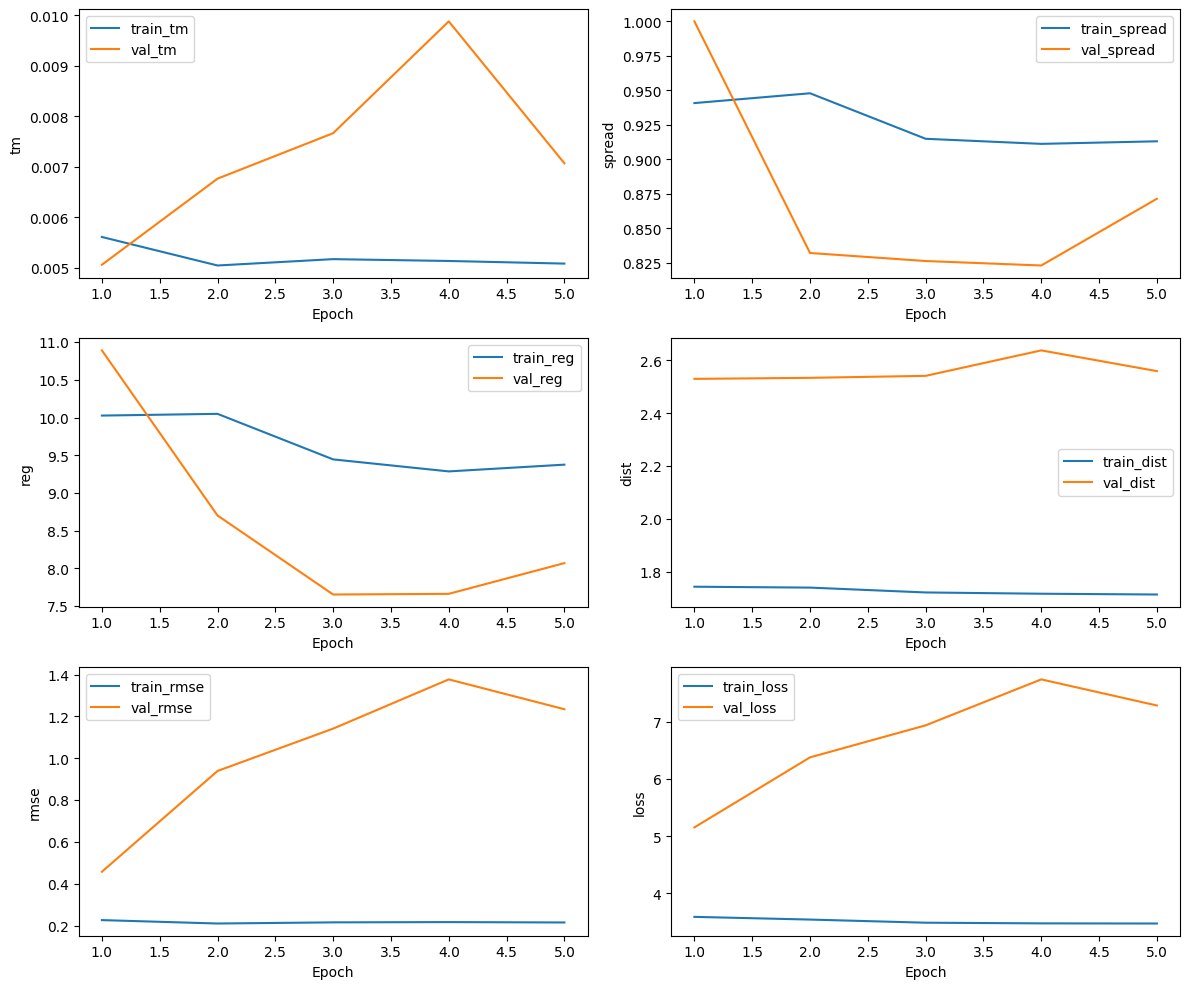

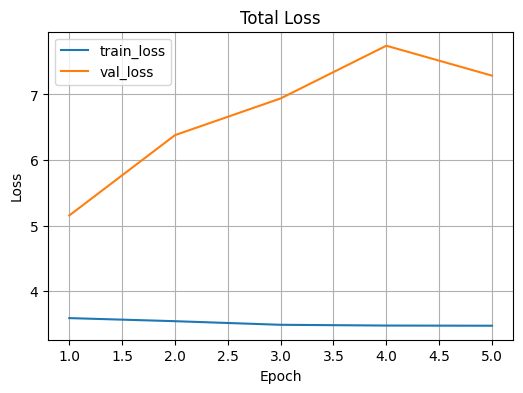

In [11]:
# =====================================================================
# 7. PLOT LOSS & METRICS HISTORY
# =====================================================================
import matplotlib.pyplot as plt
epochs = list(range(1,NUM_EPOCHS+1))

# individual curves
fig,ax = plt.subplots(3,2,figsize=(12,10))
pairs = [
  ('train_tm','val_tm'),
  ('train_spread','val_spread'),
  ('train_reg','val_reg'),
  ('train_dist','val_dist'),
  ('train_rmse','val_rmse'),
  ('train_loss','val_loss'),
]
for a,(tr,va) in zip(ax.flatten(),pairs):
    a.plot(epochs, history[tr],  label=tr)
    a.plot(epochs, history[va],  label=va)
    a.set_xlabel('Epoch'); a.set_ylabel(tr.split('_',1)[1])
    a.legend()
plt.tight_layout(); plt.show()

# total loss only
plt.figure(figsize=(6,4))
plt.plot(epochs, history['train_loss'], label='train_loss')
plt.plot(epochs, history['val_loss'],   label='val_loss')
plt.title('Total Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True); plt.show()




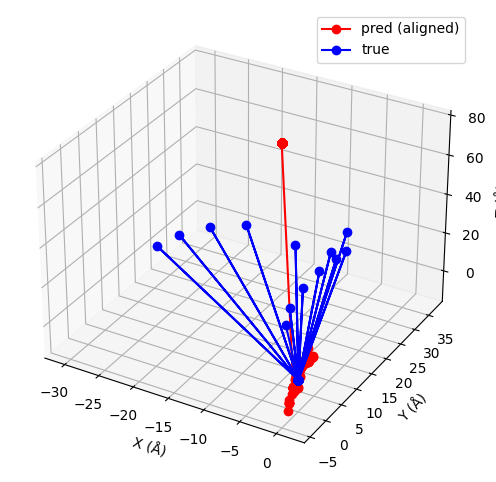

In [12]:
# =====================================================================
# 8.  VISUALIZE A BATCH OF VAL PREDICTIONS (with full Procrustes/Kabsch)
# =====================================================================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

CAP = 100.0   # must match the CAP you used to normalize coordinates during training

def kabsch_align(P, Q, mask):
    """
    Rigid‐body align P → Q over the subset mask.
    P, Q: (L,3) np.arrays
    mask: (L,) boolean
    returns: aligned copy of P
    """
    Pm = P[mask]
    Qm = Q[mask]
    # centroids
    cP = Pm.mean(axis=0)
    cQ = Qm.mean(axis=0)
    X  = Pm - cP
    Y  = Qm - cQ
    # covariance
    C  = X.T @ Y
    U, S, Vt = np.linalg.svd(C)
    d = np.sign(np.linalg.det(Vt.T @ U.T))
    R = Vt.T @ np.diag([1,1,d]) @ U.T
    # apply rotation + translation
    return (P - cP) @ R + cQ

# grab one batch from validation set
model.eval()
for batch in val_loader:
    ids, feats, coords, mask = batch
    feats, coords, mask = feats.to(DEVICE), coords.to(DEVICE), mask.to(DEVICE)
    with torch.no_grad():
        preds, _ = model(feats, coords, mask)

    # take first example in the batch
    c1p = preds[0, :, 0, :].cpu().numpy() * CAP    # (L,3) in Å
    c1t = coords[0, :, 0, :].cpu().numpy() * CAP   # (L,3) in Å
    m   = mask[0].cpu().numpy().astype(bool)       # (L,)

    # rigid‐body align prediction onto truth
    c1p_aligned = kabsch_align(c1p, c1t, m)

    # plot overlay
    fig = plt.figure(figsize=(6,6))
    ax  = fig.add_subplot(111, projection='3d')
    ax.plot(c1p_aligned[:,0], c1p_aligned[:,1], c1p_aligned[:,2],
            '-o', color='red',   label='pred (aligned)')
    ax.plot(c1t[:,0],        c1t[:,1],        c1t[:,2],
            '-o', color='blue',  label='true')
    ax.set_xlabel("X (Å)")
    ax.set_ylabel("Y (Å)")
    ax.set_zlabel("Z (Å)")
    ax.legend()
    plt.show()
    break


In [13]:
# =====================================================================
# 3b. TEST DATASET & DATALOADER
# =====================================================================
# load the test set (no labels, just sequences + ID)
test_df = pd.read_csv(f"{COMP_DIR}/test_sequences.csv")  # or .parquet if that’s what you have
# make sure it has a column named 'target_id' (rename if necessary)
if 'ID' in test_df.columns and 'target_id' not in test_df.columns:
    test_df = test_df.rename(columns={'ID':'target_id'})

# build a test_loader using exactly the same LazyRNA (coords will be all zeros,
# but you need that tensor shape to feed into the model)
test_loader = DataLoader(
    LazyRNA(test_df, MAX_LEN, CACHE_DIR),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
print(f"TEST SIZE: {len(test_df):,} sequences → loader batches:", len(test_loader))


TEST SIZE: 12 sequences → loader batches: 2


In [14]:
# =====================================================================
# 9.  TEST PREDICTIONS → submission.csv (with correct Å‐scaling)
# =====================================================================
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

CAP = 100.0  # same CAP used during training

def predict_long_sequence(model, seq, max_len, device):
    """
    Break `seq` into windows of length max_len, run each window through the model,
    stitch back together the center C1' coords, and return an (L,3) ndarray.
    """
    model.eval()
    L = len(seq)
    feat_full = one_hot(seq, L)    # (L, VOC_SIZE)
    pad       = (-L) % max_len
    feat_pad  = np.pad(feat_full,
                      ((0,pad),(0,0)),
                      mode='constant', constant_values=0.0)
    W         = feat_pad.shape[0] // max_len
    coords_out = np.zeros((W*max_len, 3), dtype=np.float32)

    with torch.no_grad():
        for wi in range(W):
            wfeat  = feat_pad[wi*max_len:(wi+1)*max_len]
            feats  = torch.from_numpy(wfeat[None]).to(device)        # (1,max_len,VOC)
            coords0= torch.zeros(1, max_len, 1, 3, device=device)    # dummy padding
            mask0  = torch.ones(1, max_len, dtype=torch.bool, device=device)
            preds, _ = model(feats, coords0, mask0)                  # (1,max_len,40,3)
            c1 = preds[0, :, 0, :].cpu().numpy()                     # (max_len,3)
            coords_out[wi*max_len:(wi+1)*max_len] = c1

    return coords_out[:L]

# 9a) load sample_submission for ordering
sample     = pd.read_csv(f"{COMP_DIR}/sample_submission.csv")
sample_ids = sample["ID"].tolist()
cols       = sample.columns.tolist()

# 9b) test loader & seq dict
test_df = pd.read_csv(f"{COMP_DIR}/test_sequences.csv")
if "ID" in test_df.columns:
    test_df = test_df.rename(columns={"ID":"target_id"})
test_loader   = DataLoader(LazyRNA(test_df, MAX_LEN, CACHE_DIR),
                           batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=2, pin_memory=True)
test_seq_dict = dict(zip(test_df.target_id, test_df.sequence))

# 9c) predict & collect
model.eval()
pred_rows = {}

with torch.no_grad():
    for tids, feat, coords, mask in test_loader:
        feat, coords, mask = feat.to(DEVICE), coords.to(DEVICE), mask.to(DEVICE)
        for b, tid in enumerate(tids):
            seq = test_seq_dict[tid]
            L   = len(seq)

            if L <= MAX_LEN:
                preds, _ = model(feat[b:b+1], coords[b:b+1], mask[b:b+1])
                c1_all = preds[0, :L, :5, :].cpu().numpy()   # (L,5,3)
            else:
                c1_full = predict_long_sequence(model, seq, MAX_LEN, DEVICE)  # (L,3)
                c1_all  = np.repeat(c1_full[:,None,:], 5, axis=1)            # (L,5,3)

            # scale back to Å
            c1_all *= CAP

            # build per‐residue rows
            for i in range(L):
                row_id = f"{tid}_{i+1}"
                base   = seq[i]
                row    = {"ID":row_id, "resname":base, "resid":i+1}
                for j in range(5):
                    x, y, z = c1_all[i, j]
                    row[f"x_{j+1}"] = float(x)
                    row[f"y_{j+1}"] = float(y)
                    row[f"z_{j+1}"] = float(z)
                pred_rows[row_id] = row

# 9d) re‐index to sample_submission
out = []
for rid in sample_ids:
    if rid in pred_rows:
        out.append(pred_rows[rid])
    else:
        # fill missing with zeros
        tid, idx = rid.rsplit("_",1)
        base      = test_seq_dict[tid][int(idx)-1]
        empty     = {"ID":rid, "resname":base, "resid":int(idx)}
        for axis in ("x","y","z"):
            for j in range(1,6):
                empty[f"{axis}_{j}"] = 0.0
        out.append(empty)

df_sub = pd.DataFrame(out, columns=cols)
df_sub.to_csv("submission.csv", index=False)
print(f"Wrote submission.csv with {len(df_sub)} rows.")


Wrote submission.csv with 2515 rows.


In [15]:
df_sub

,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,R1107_1,G,1,62.019707,66.070267,52.090542,12.297071,9.417640,-14.829838,-12.445143,0.747276,-3.154823,-6.143993,3.231283,-16.531841,16.121483,-18.724201,1.852594
1,R1107_2,G,2,65.590332,70.865135,55.894176,13.213900,9.118304,-15.936007,-12.883247,0.289433,-4.336236,-6.968310,2.669398,-16.840210,17.042389,-19.176767,1.737347
2,R1107_3,G,3,63.089828,74.048691,55.993523,12.662066,6.877064,-15.233048,-11.128674,-1.360911,-7.140666,-7.908057,1.360064,-14.324634,17.952433,-17.344536,0.715798
3,R1107_4,G,4,62.909653,66.996735,53.013527,12.494419,9.334903,-15.131315,-12.576895,0.653461,-3.378422,-6.316265,3.129497,-16.627485,16.259857,-18.825027,1.835734
4,R1107_5,G,5,63.289608,74.086670,56.146103,12.699701,6.901701,-15.303276,-11.189408,-1.341737,-7.110352,-7.911526,1.374853,-14.391242,17.935358,-17.392269,0.734594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,R1189_114,U,114,62.680065,66.187912,52.690105,12.383182,9.376214,-15.099746,-12.600533,0.736644,-3.145904,-6.198883,3.238741,-16.662537,16.051353,-18.799324,1.879798
2511,R1189_115,U,115,58.743797,62.149914,48.637581,11.512771,9.714884,-13.767435,-12.004581,1.134581,-2.192894,-5.447565,3.679590,-16.220833,15.445249,-18.336067,1.940155
2512,R1189_116,U,116,61.415215,64.655525,51.400787,12.070462,9.437414,-14.703102,-12.417240,0.864576,-2.805496,-5.931901,3.410338,-16.514883,15.755512,-18.611212,1.893969
2513,R1189_117,U,117,58.376514,61.344727,48.238041,11.379079,9.711627,-13.689015,-11.978144,1.194279,-2.006746,-5.327103,3.778897,-16.197283,15.232629,-18.257713,1.956405


In [16]:
# cleanup
import os, shutil
for fn in os.listdir("/kaggle/working"):
    if fn!="submission.csv":
        p=os.path.join("/kaggle/working",fn)
        (shutil.rmtree(p) if os.path.isdir(p) else os.remove(p))
print("✅ cleaned up.")

✅ cleaned up.
